## Implement ReAct with LangGraph

ReAct(Reasoning+Acting) is a framewpork where an LLM:

- Reasons step-by-stepp (e.g. decomposes questions, makes decisions)
- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG: Think -? Retrieve -> Observe -> Reflect -> Final Answer

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.agents import create_agent
from langchain_core.tools.simple import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from typing import List, Annotated, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

d:\RAG\AgenticAI-LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Document Processing

docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter()
chunks = splitter.split_documents(docs)

embeddings= HuggingFaceEmbeddings()
llm = init_chat_model("groq:openai/gpt-oss-20b")

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [3]:
retriever.invoke('What are agents')

[Document(id='040f8426-d431-4b06-83db-b3fa95bb25e7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [4]:
def retriever_tool_func(query: str)-> str:
    print("Using RAGRetriever tool")
    docs= retriever.invoke(query)
    return '\n'.join([doc.page_content for doc in docs])

In [5]:
retriever_tool_func('What are autonomous agents')

Using RAGRetriever tool


'LLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentialit

In [6]:
retriever_tool = Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func= retriever_tool_func
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [7]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAG\\AgenticAI-LangGraph\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

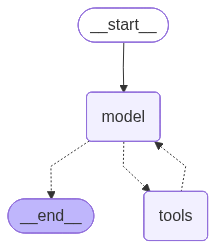

In [8]:
tools = [retriever_tool, wiki_tool]

# create native Langgraph reAct agent
react_node = create_agent(llm,tools)
react_node

In [9]:
# Langgraph Agent state

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

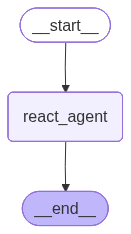

In [10]:
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()

graph

In [11]:
# Run the agent
# Use a query that explicitly asks for knowledge base info to encourage RAGRetriever usage
user_query = "Use the RAGRetriever tool to find: What is an agent loop? Then search Wikipedia for: how autonomous agents work"
state={'messages':[HumanMessage(content=user_query)]}
result= graph.invoke(state)

print(f"Final Answer:\n{result['messages'][-1].content}")

Using RAGRetriever tool
Final Answer:
**What is an agent loop?**  
An *agent loop* (sometimes called the **perception–action loop**) is the continuous cycle that an autonomous system follows to interact with its environment.  
1. **Perception** – The agent senses or receives data from the world (e.g., sensor readings, user input, or external API responses).  
2. **Decision / Planning** – Using its internal model or a learned policy, the agent processes the percepts to decide on a goal or an action.  
3. **Action** – The agent executes the chosen action (e.g., moving a robot, calling an API, or sending a message).  
4. **Feedback** – The environment reacts, producing new percepts that feed back into step 1, closing the loop.  

This loop is the fundamental mechanism by which autonomous agents continuously adapt to changing conditions and pursue their objectives. (See “Intelligent agent” – *Wikipedia*)

---

**How autonomous agents work**  
An autonomous agent is a software or robotic en

In [12]:
# Debug: Check what tool calls were made
print("All messages in result:")
for i, msg in enumerate(result['messages']):
    print(f"\nMessage {i}: {type(msg).__name__}")
    print(f"Content preview: {str(msg.content)[:200]}...")
    if hasattr(msg, 'tool_calls'):
        print(f"Tool calls: {msg.tool_calls}")

All messages in result:

Message 0: HumanMessage
Content preview: Use the RAGRetriever tool to find: What is an agent loop? Then search Wikipedia for: how autonomous agents work...

Message 1: AIMessage
Content preview: ...
Tool calls: [{'name': 'RAGRetriever', 'args': {'__arg1': 'What is an agent loop?'}, 'id': 'fc_b7631e0f-884a-4606-8fec-08939f482afb', 'type': 'tool_call'}]

Message 2: ToolMessage
Content preview: Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)

The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Ine...

Message 3: AIMessage
Content preview: ...
Tool calls: [{'name': 'wikipedia', 'args': {'query': 'how autonomous agents work'}, 'id': 'fc_7af4b92e-74d0-4d75-8100-8ea5a1c7ef5b', 'type': 'tool_call'}]

Message 4: ToolMessage
Content preview: Page: Intelligent agent
Summary: In artificial intelligence, an intelligent agent is an entity that perceives its environment, takes acti